In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

from tqdm import tqdm

import torch

from lim_mock_generator.utils.training_utils import MyDataset
from lim_mock_generator.model.transformer import my_model

from matplotlib.colors import LogNorm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_running_mean(x, value, window_size, show_diff=False, **kwargs):
    cumsum = np.cumsum(np.insert(value, 0, 0))
    y = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    x = x[window_size-1:]

    if len(y) == 0:
        print("Warning: No data to plot.")
        return None, None
    
    if show_diff:
        y -= y.min()
        plt.plot(x, y, **kwargs)
    else:
        plt.plot(x, y, **kwargs)
    
    return x, y

def my_savefig(fout):
    plt.tight_layout()
    plt.savefig(fout, bbox_inches="tight")
    print(f"Saved figure to {fout}")

param_names = [r"$\tilde{\rm SFR}$", r"$\tilde{d}$", r"$\tilde{v}_r$", r"$\tilde{v}_\theta$"]
param_labels = ["sfr", "d", "vr", "vt"]

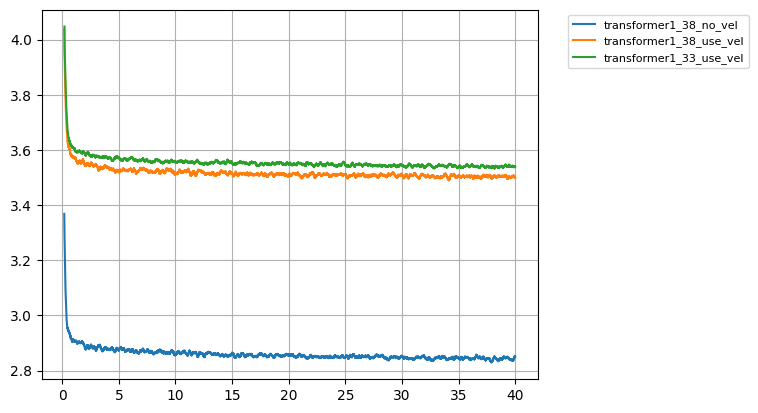

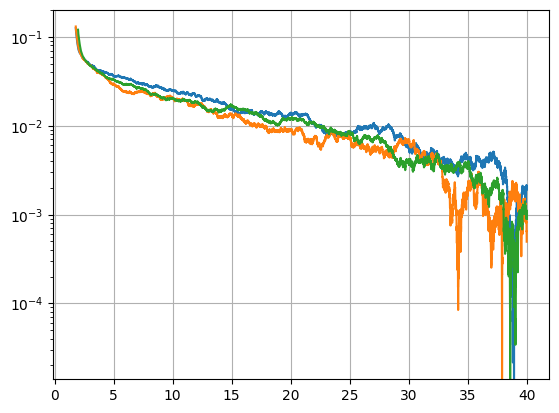

In [3]:
model_dir_list = [
    "./runs/output_transformer/transformer1_38_no_vel",
    "./runs/output_transformer/transformer1_38_use_vel",
    "./runs/output_transformer/transformer1_33_use_vel"
]

plt.figure()
for model_dir in model_dir_list:
    loss = np.loadtxt(f"{model_dir}/log.txt", comments="#")
    x = loss[:,0]
    plot_running_mean(x, loss[:,2], 100, label=model_dir.split("/")[-1])

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.figure()
for model_dir in model_dir_list:
    loss = np.loadtxt(f"{model_dir}/log.txt", comments="#")
    x = loss[:,0]
    plot_running_mean(x, loss[:,2], 1000, show_diff=True, label=model_dir.split("/")[-1])
    
plt.yscale("log")
plt.grid()


opt:  Namespace(gpu_id='1', output_dir='./output/transformer1_33_use_vel', seed=12345, max_length=50, use_dist=True, use_vel=True, data_path='./TNG_data/TNG300-1_33.h5', train_ratio=0.9, batch_size=512, num_epochs=40, lr=0.001, dropout=0.0, use_sampler=True, save_freq=20, model_name='transformer1', d_model=128, num_layers=4, num_heads=8, num_features_out=100, num_features_in=4, norm_params=[[11.0, 15.0], [-3.2, 3.0], [-3.0, 1.0], [-4.0, 4.0], [-2.0, 4.0]])
Transformer1(
  (embedding_layers): Sequential(
    (0): Linear(in_features=4, out_features=127, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=127, out_features=127, bias=True)
  )
  (context_embedding_layers): Sequential(
    (0): Linear(in_features=1, out_features=127, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=127, out_features=127, bias=True)
  )
  (decoder): TransformerDecoder(
    (layer

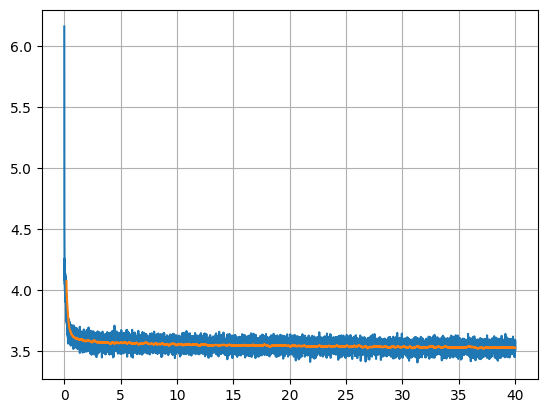

In [4]:
model_dir = "./runs/output_transformer/transformer1_33_use_vel"
output_dir = "{}/figures".format(model_dir)
os.makedirs(output_dir, exist_ok=True)

### plot loss 
loss = np.loadtxt("{}/log.txt".format(model_dir), comments="#")
plt.figure()
x = loss[:,0]
plt.plot(x, loss[:,1], label="train")

_x, loss_val = plot_running_mean(x, loss[:,1], 100, label="val")
#plt.yscale("log")
#plt.ylim([2.3,2.4])
plt.grid()

### load parameters
with open("{}/args.json".format(model_dir), "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.loadtxt("norm_params.txt")
xmin, xmax = norm_params[:, 0], norm_params[:,1]

### load model
model = my_model(opt)
model.to(device)

model.load_state_dict(torch.load("{}/model.pth".format(model_dir)))
#model.load_state_dict(torch.load(f"{model_dir}/model_ep20.pth"))

model.eval()
print(model)

0.2500: 0.6964 0.5512 0.0000 | 
0.2500: 0.0000 0.5553 0.5677 | 
0.2500: 0.5000 0.6238 0.3541 | 
0.2500: 0.5548 0.7106 0.6681 | 
0.2500: 0.7065 0.6815 0.3556 0.1557 0.1250 0.0000 | 
0.2500: 0.0000 0.4730 0.6364 0.5862 0.5318 0.6242 | 
0.2500: 0.5000 0.7570 0.7482 0.7855 0.7801 0.6917 | 
0.2500: 0.6623 0.5990 0.6966 0.7318 0.7373 0.7108 | 
0.2500: 0.6763 0.4055 0.3685 0.3297 0.3360 0.2818 0.2495 0.1204 0.0000 | 
0.2500: 0.0000 0.3647 0.5651 0.5272 0.5320 0.6233 0.5453 0.5718 0.5407 | 
0.2500: 0.5000 0.7219 0.2615 0.7719 0.7102 0.5528 0.2645 0.7867 0.8133 | 
0.2500: 0.5239 0.6393 0.5938 0.6916 0.6972 0.7447 0.6739 0.7327 0.7449 | 
0.2500: 0.7050 0.2027 0.0000 | 
0.2500: 0.0000 0.6136 0.4995 | 
0.2500: 0.5000 0.7845 0.7594 | 
0.2500: 0.5008 0.7399 0.6666 | 
0.2500: 0.6882 0.4724 0.4456 0.2684 0.2436 0.2653 0.2338 0.0000 | 
0.2500: 0.0000 0.5563 0.4708 0.4654 0.5048 0.5792 0.5704 0.5511 | 
0.2500: 0.5000 0.7573 0.7709 0.2202 0.8215 0.7842 0.8022 0.2094 | 
0.2500: 0.5209 0.6856 0.7091 0.6903

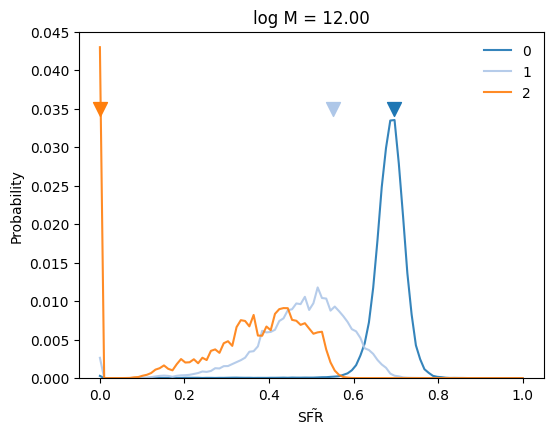

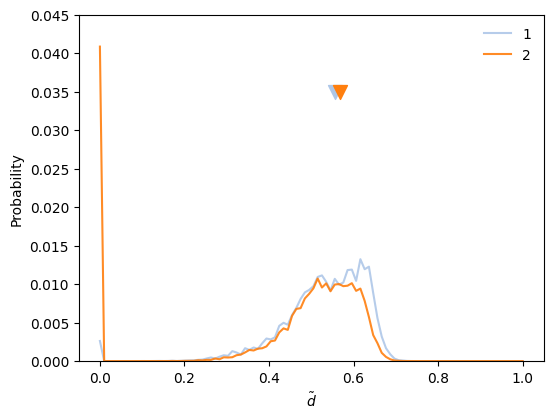

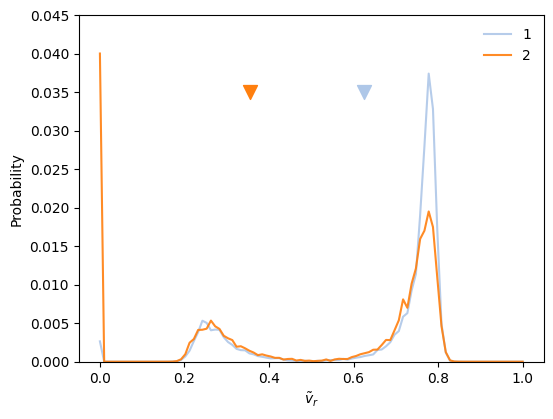

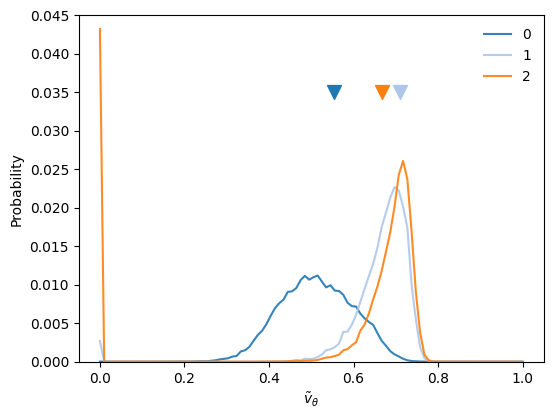

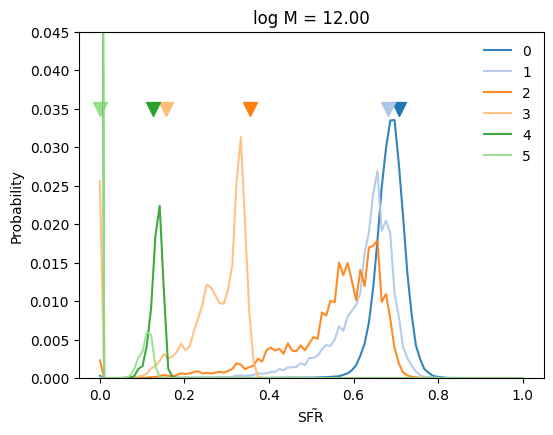

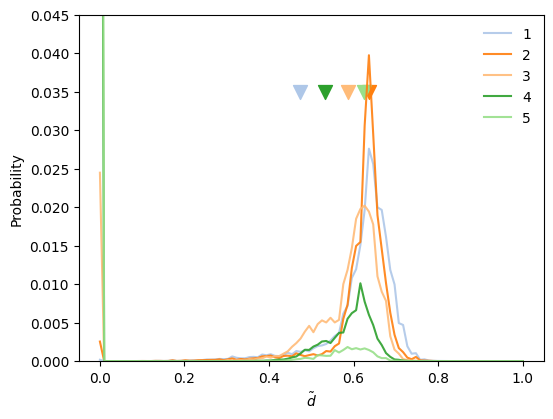

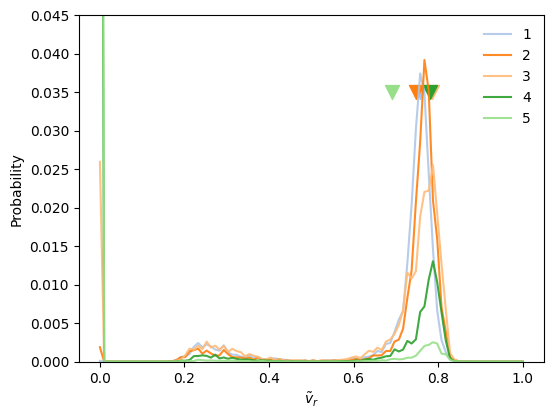

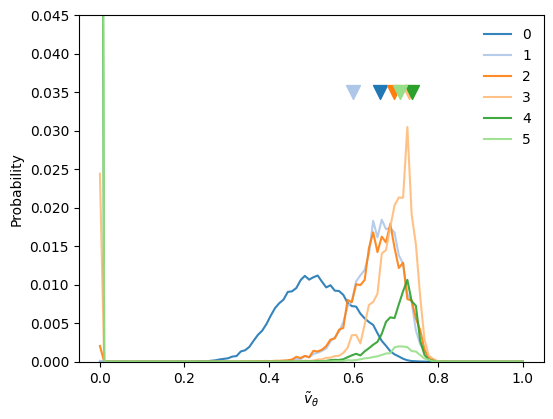

In [24]:
## Quick check of the output and probability
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

threshold = ( -3.0 - xmin[1] ) / ( xmax[1] - xmin[1])
def calc_length(x, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

x_test_physical_unit = 12.00
x_test = ( x_test_physical_unit - xmin[0] ) / ( xmax[0] - xmin[0] )
x_test = [ x_test ] * 10
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
generated_test, prob = model.generate(x_test)
generated_test = generated_test.detach().cpu().numpy()
prob = prob.detach().cpu().numpy()

length_generated_test = calc_length(generated_test)

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10

for i, (x, g) in enumerate(zip(x_test, generated_test)):
    for iparam in range(opt.num_features_in):
        print(f"{x.item():.4f}: ", end="")
        for j, gg in enumerate(g[:,iparam]):
            print(f"{gg:.4f} ", end="")
            if j == length_generated_test[i]:
                break

        print("| ")

        if i < 2:
            plt.figure(figsize=(6, 4.5))
            if iparam == 0:
                plt.title("log M = {:.2f}".format(x_test_physical_unit))
            #ylim = 0.0001, 0.1
            ylim = 0, 0.045
            for k in range(length_generated_test[i]+1):
                label = f"{k}"
                if k == 0 and ( iparam == 1 or iparam == 2 ):
                    continue
                plt.plot(np.linspace(0, 1, opt.num_features_out), prob[i,k,iparam], label=label, color=colors[k], alpha=0.9)
                #plt.vlines(g[k,iparam], *ylim, colors=colors[k], linestyles="dashed")
                plt.scatter(g[k,iparam], 0.035, marker="v", color=colors[k], s=100)

            #plt.vlines(threshold, *ylim, colors="gray", ls="dashed")

            plt.ylim(*ylim)
            #plt.yscale("log")
            plt.xlabel(f"{param_names[iparam]}")
            plt.ylabel("Probability")
            plt.legend(frameon=False)
            
            plt.savefig("{}/prob_{}_{:d}.pdf".format(output_dir, param_labels[iparam], i))
        #break

In [5]:
### True data ###
data_path = "../TNG_data"

ndata = None
#ndata = 10000
dataset_true = MyDataset(data_path, max_length=opt.max_length, norm_params=norm_params, ndata=ndata, use_dist=opt.use_dist, use_vel=opt.use_vel)
x_true = dataset_true.x
y_true = dataset_true.y_padded
x_true_Msun = x_true * (xmax - xmin) + xmin

### set threshold
#threshold = 1. / opt.num_features_out
threshold = ( -3.0 - xmin[1] ) / ( xmax[1] - xmin[1])
bin_of_threshold = int(threshold * opt.num_features_out)
print(threshold)
print(bin_of_threshold)

prob_threshold = 1e-5 # p = 0 if p < prob_threshold

### model output ###
count = 0
generated = []
batch_size = opt.batch_size
batch_size = 1024
num_batch = (len(x_true) + batch_size - 1) // batch_size
count = 0
for i in tqdm(range(num_batch)):
    tmp = x_true[count:count+batch_size].to(device)
    gen, _ = model.generate(tmp, stop_criterion=threshold, prob_threshold=prob_threshold)
    generated.append(gen)
    count += batch_size
generated = torch.cat(generated, dim=0)

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

# Loading halo data from ./TNG_data/TNG300-1_33.h5


/tmp/ipykernel_3949372/2996534419.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_true_Msun = x_true * (xmax - xmin) + xmin


0.03225806451612906
3


100%|██████████| 280/280 [03:15<00:00,  1.43it/s]


In [40]:
def calc_length(x, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

### calculate length ###
length_true = calc_length(y_true)
length_generated = calc_length(generated)

### binning ###
nbins = 20
xbins = np.linspace(0, 1, nbins+1)
xbins_physical_unit = xbins[:,None] * (xmax[None,:] - xmin[None,:]) + xmin[None,:] # (num_bins, num_params)

xbin_indices_true = np.digitize(x_true, xbins) - 1 # (num_samples,)
ybin_indices_true = np.digitize(y_true, xbins) - 1 # (num_samples, seq_length, num_params)
ybin_indices_generated = np.digitize(generated, xbins) - 1 # (num_samples, seq_length, num_params)
 
length_bins = np.arange(1, opt.max_length+1)
length_bin_indices_true = np.digitize(length_true, length_bins) - 1 # (num_samples,)
length_bin_indices_generated = np.digitize(length_generated, length_bins) - 1 # (num_samples,)
 
# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = (10**y_true[:,:,0]) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = (10**generated[:,:,0]) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)

y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
y_true_tot = np.log10(y_true_tot) # (num_samples,)
y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)
y_generated_tot = np.log10(y_generated_tot) # (num_samples,)

/tmp/ipykernel_3949372/3289246733.py:41: RuntimeWarning: divide by zero encountered in log10
  y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
/tmp/ipykernel_3949372/3289246733.py:43: RuntimeWarning: divide by zero encountered in log10
  y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)


Saved figure to ./output/transformer1_33_use_vel/figures/hist_length.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/hist_length_sfr_bin.png
Saved figure to ./output/transformer1_33_use_vel/figures/hist_total_sfr.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/hist_central_sfr_logm0.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/hist_central_sfr_logm5.pdf


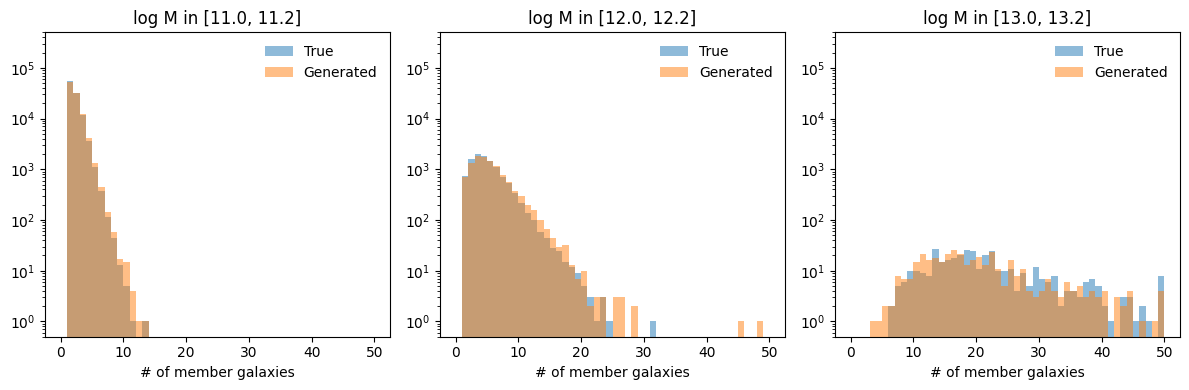

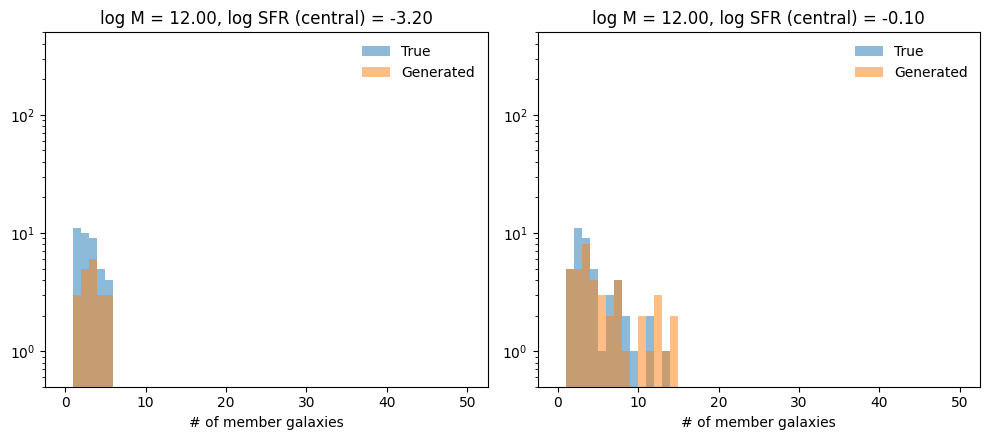

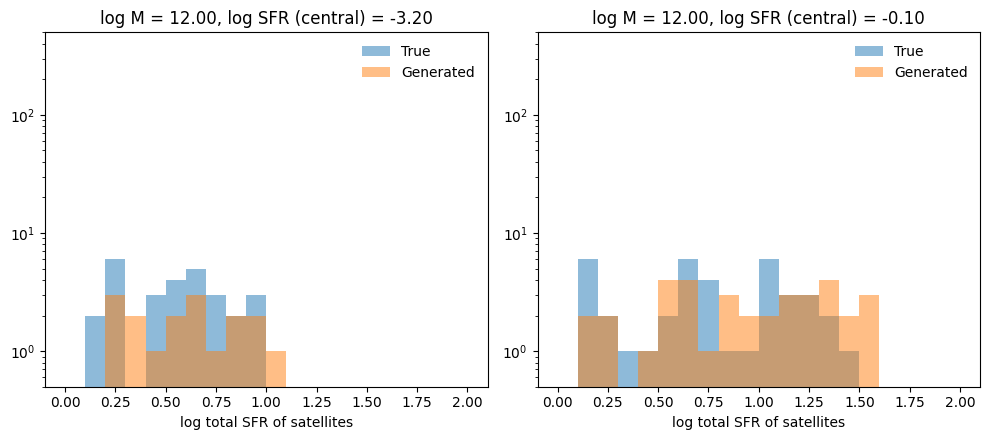

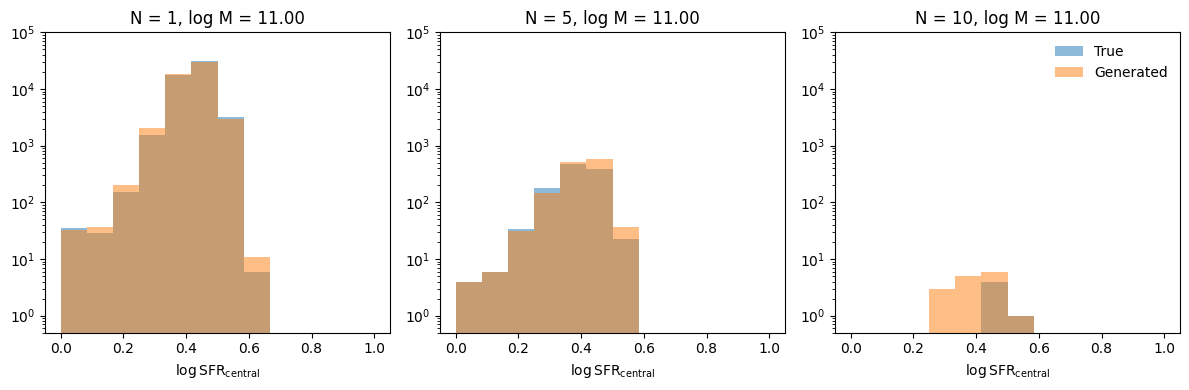

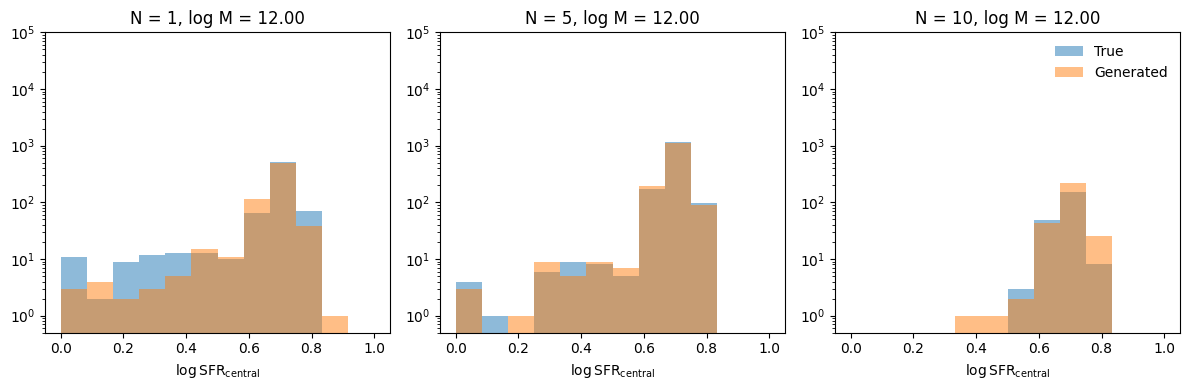

In [21]:
### Histograms 
density = False 
#density = True

list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i in enumerate(list_to_show):
    plt.subplot(1,len(list_to_show),count+1)
    plt.title(f"log M in [{xbins_physical_unit[i,0]:.1f}, {xbins_physical_unit[i+1,0]:.1f}]")
    indices = np.where(xbin_indices_true == i)[0]
    plt.hist(length_true[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="True", ls="-")
    plt.hist(length_generated[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="Generated", ls="--")
    plt.yscale("log")
    plt.xlabel("# of member galaxies")
    if density:
        plt.ylim([1e-3, 1.5])
    else:
        plt.ylim([5e-1, 5e5])
    plt.legend(frameon=False)

fout = f"{output_dir}/hist_length.pdf"
my_savefig(fout)


list_to_show = [5]
y_list_to_show = [0, 10]
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10
plt.figure(figsize=(len(y_list_to_show)*5, len(list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)

    for j in y_list_to_show:
        plt.subplot(len(list_to_show),len(y_list_to_show),count+1)
        plt.title(f"log M = {xbins_physical_unit[i,0]:.2f}, log SFR (central) = {xbins_physical_unit[j,1]:.2f}")

        indices = np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0]
        plt.hist(length_true[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="True", ls="-")
        indices = np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        plt.hist(length_generated[indices], range=(0,opt.max_length), bins=opt.max_length, alpha=0.5, density=density, label="Generated", ls="--")
        plt.yscale("log")
        plt.xlabel("# of member galaxies")

        count += 1

        if density:
            plt.ylim([1e-3, 1.5])
        else:
            plt.ylim([5e-1, 5e2])
        plt.legend(frameon=False)

fout = f"{output_dir}/hist_length_sfr_bin.png"
my_savefig(fout)


list_to_show = [5]
y_list_to_show = [0, 10]
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10
plt.figure(figsize=(len(y_list_to_show)*5, len(list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)

    for j in y_list_to_show:
        plt.subplot(len(list_to_show),len(y_list_to_show),count+1)
        plt.title(f"log M = {xbins_physical_unit[i,0]:.2f}, log SFR (central) = {xbins_physical_unit[j,1]:.2f}")

        indices = np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0]
        plt.hist(y_true_sat_tot[indices], range=(0,2), bins=20, alpha=0.5, density=density, label="True", ls="-")
        indices = np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        plt.hist(y_generated_sat_tot[indices], range=(0,2), bins=20, alpha=0.5, density=density, label="Generated", ls="--")
        plt.yscale("log")
        plt.xlabel("log total SFR of satellites")

        count += 1

        if density:
            plt.ylim([1e-3, 3])
        else:
            plt.ylim([5e-1, 5e2])
        plt.legend(frameon=False)

fout = f"{output_dir}/hist_total_sfr.pdf"
my_savefig(fout)

list_to_show = [0, 5]
length_list_to_show = [1, 5, 10]
for i_logm in list_to_show:
    base_mask = (xbin_indices_true == i_logm)
    #base_mask = np.ones(len(logm_bin_indices_true), dtype=bool)
    #base_mask = (i_logm < logm_bin_indices_true) & (logm_bin_indices_true < i_logm + 5)
    bins_l = 12
    for iparam in range(1): # only for the first parameter    
        plt.figure(figsize=(len(length_list_to_show)*4, 4))
        for count, i in enumerate(length_list_to_show):
            plt.subplot(1, len(length_list_to_show), count+1)
            plt.title(f"N = {i}, log M = {xbins_physical_unit[i_logm, 0]:.2f}")
            indices = np.where((length_bin_indices_true == i-1) & base_mask )[0]
            plt.hist(y_true[indices,0,iparam], range=(0,1), bins=bins_l, alpha=0.5, density=density, label="True", ls="-")
            indices = np.where((length_bin_indices_generated == i-1) & base_mask)[0]
            plt.hist(generated[indices,0,iparam], range=(0,1), bins=bins_l, alpha=0.5, density=density, label="Generated", ls="-")

            if iparam == 0:
                plt.xlabel(r"$\log {\rm SFR}_{\rm central}$")
            if iparam == 1:
                plt.xlabel(r"$\log d_{\rm satellite}$")
                
            plt.yscale("log")
            if not density:
                plt.ylim([5e-1, 1e5])
        plt.legend(frameon=False)

        fout = f"{output_dir}/hist_central_sfr_logm{i_logm}.pdf" 
        my_savefig(fout)

Saved figure to ./output/transformer1_33_use_vel/figures/logm_x0.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/logm_x1.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/logm_x2.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/logm_x3.pdf


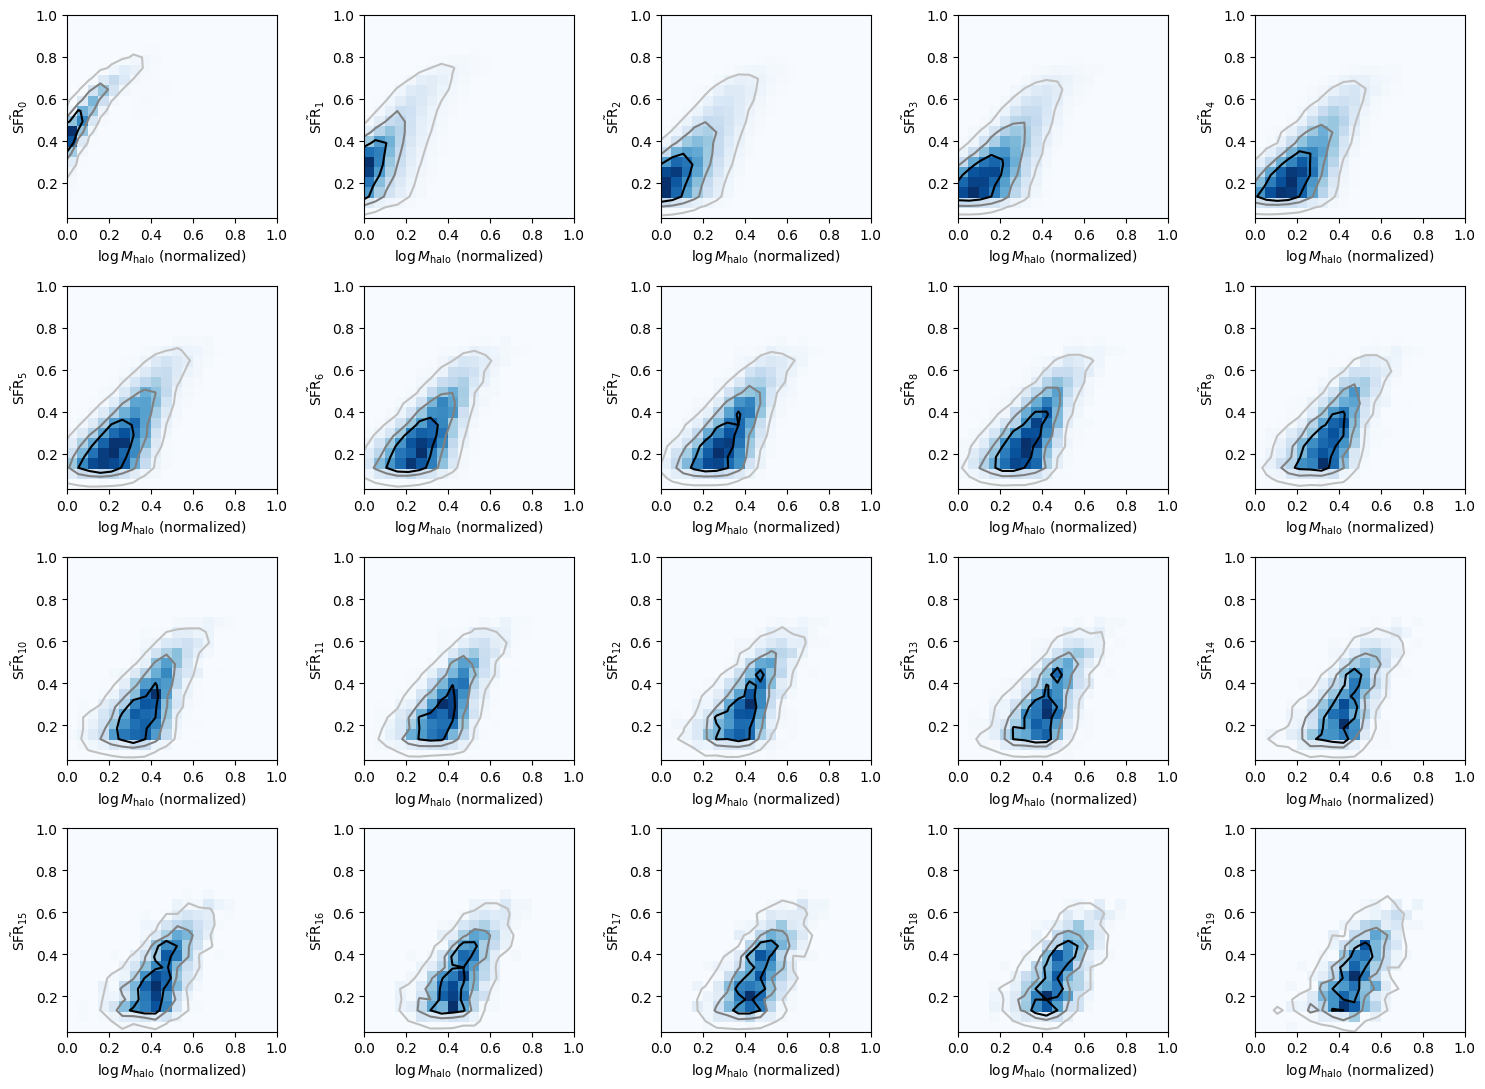

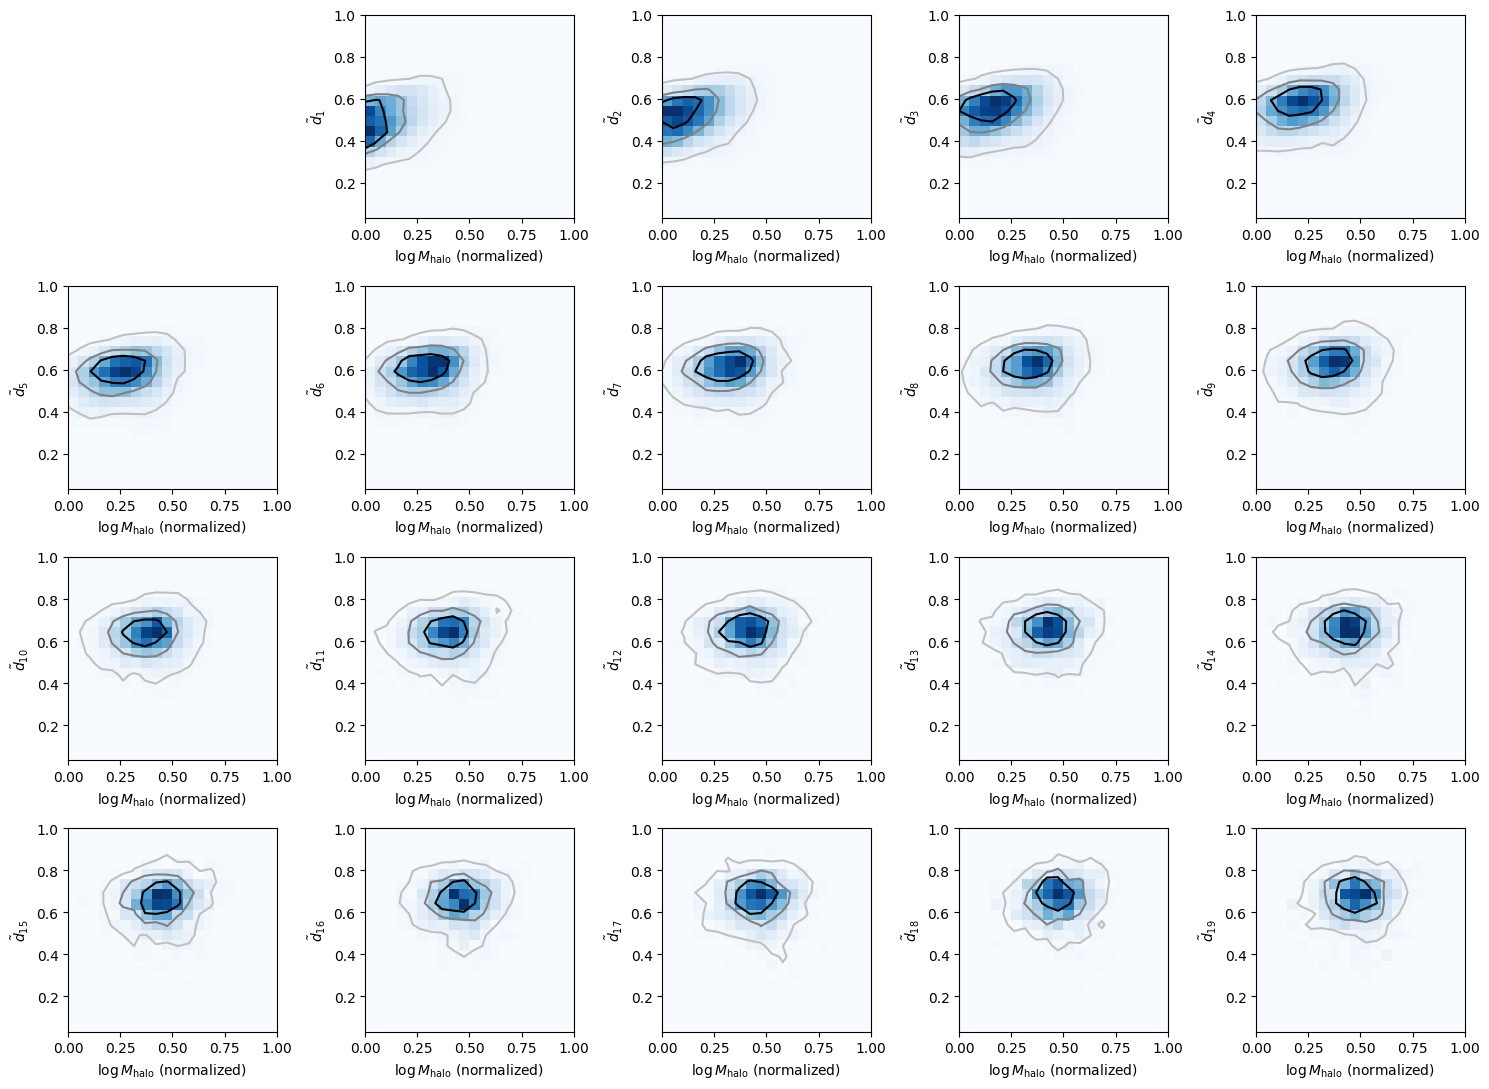

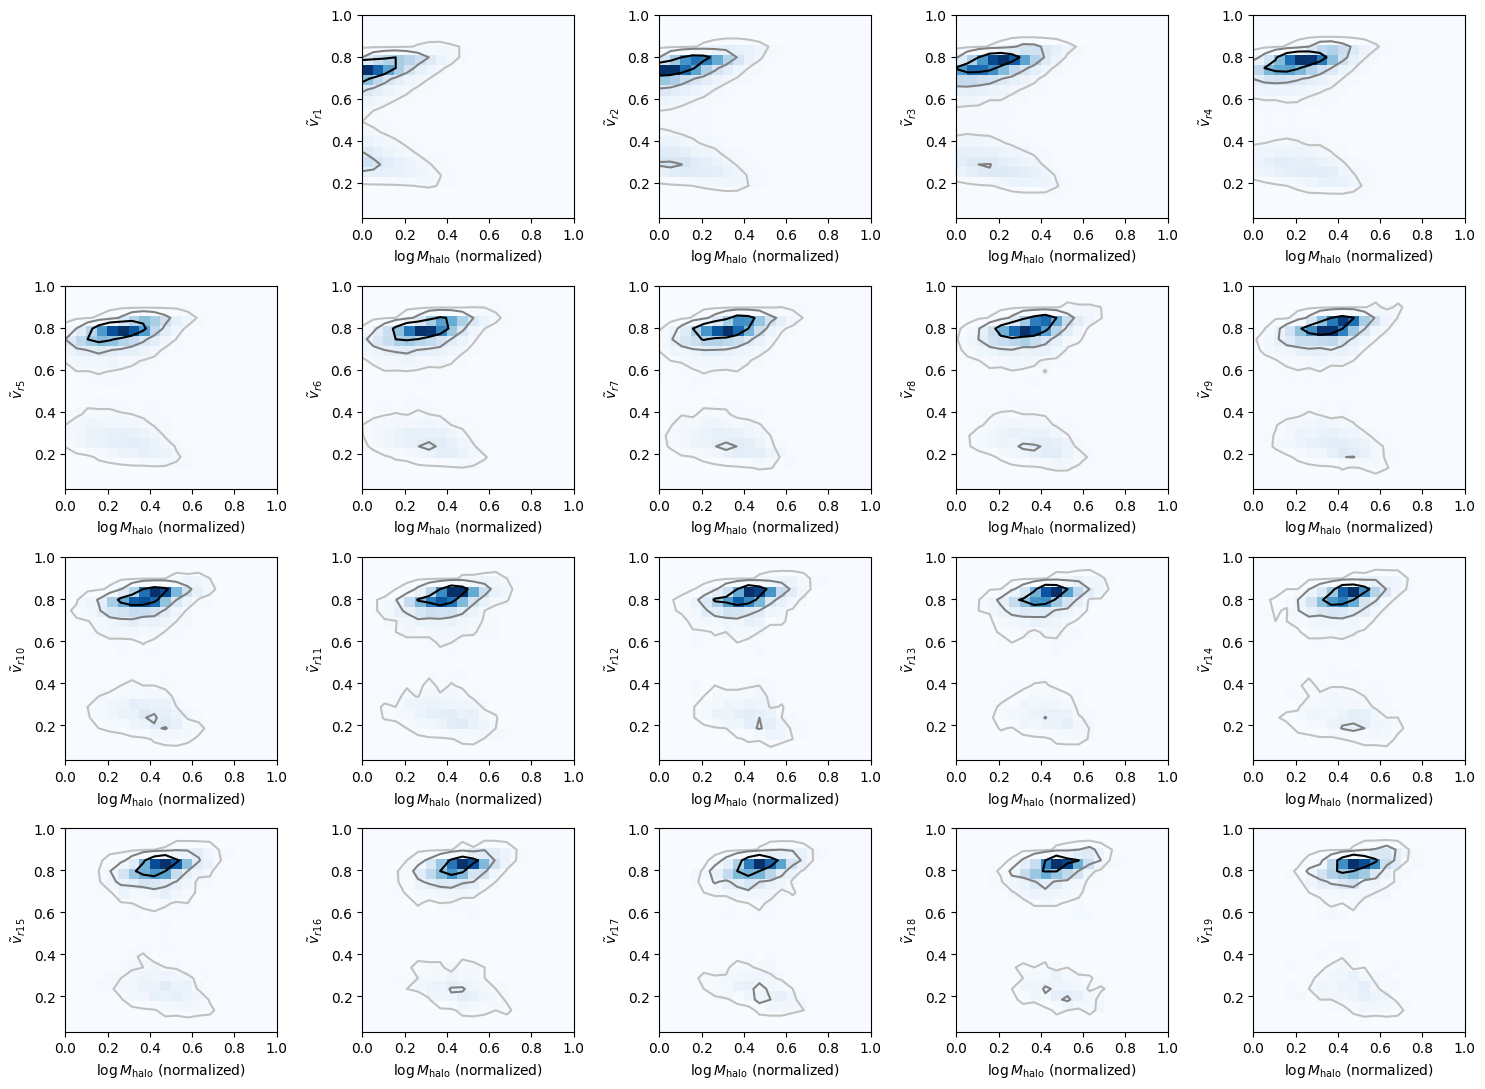

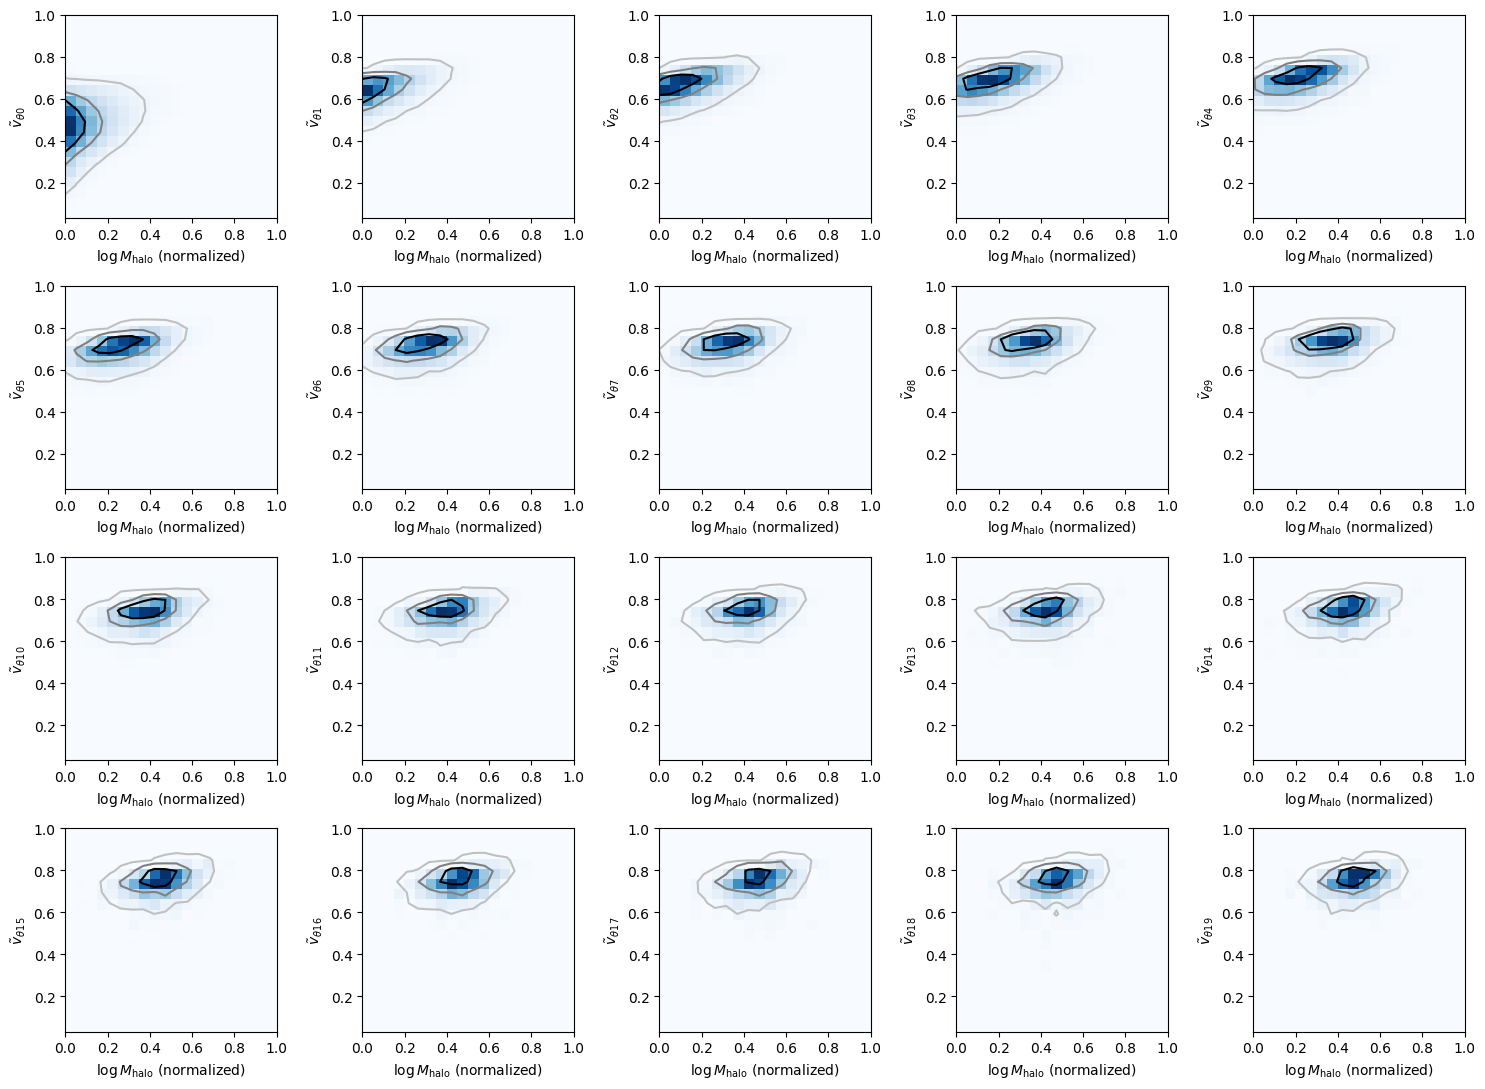

In [18]:
### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

show_diff = False

gray_colors = ['#C0C0C0', '#808080', '#000000'] 

max_length_to_show = 20

def compute_contoure_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

for iparam in range(opt.num_features_in):
    plt.figure(figsize=(15, 11))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        if iparam == 2 and i == 0:
            continue

        mask = length_bin_indices_true > i - 1
        xnow_true = x_true[mask]
        ynow_true = y_true[mask]
        mask = length_bin_indices_generated > i - 1
        xnow = x_true[mask]
        ynow = generated[mask]

        plt.subplot(4,5,i+1)    

        if show_scatter:
            plt.scatter(xnow_true, ynow_true[:,i,iparam], s=1, color="blue", alpha=0.5)
            plt.scatter(xnow, ynow[:,i,iparam], s=1, color="red", alpha=0.5)
        else:
            hist_range = [[0,1],[threshold,1]]
            extent = [0,1,threshold,1]
            hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam], bins=20, range=hist_range)
            plt.imshow(hist[0].T, extent=extent, cmap="Blues", origin="lower", aspect="auto")
            grid_data, levels = compute_contoure_levels(hist[0])
            hist = np.histogram2d(xnow, ynow[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contoure_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=gray_colors, levels=levels)

        plt.ylabel(param_names[iparam]+r"$_{%d}$" % i)
        plt.xlabel(r"$\log M_{\rm halo}\ (\rm normalized)$")

    if show_diff:
        plt.figure(figsize=(15,11))
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        for i in range(max_length_to_show):
            mask = length_bin_indices_true > i
            xnow_true = x_true[mask]
            ynow_true = y_true[mask]
            mask = length_bin_indices_generated > i
            xnow = x_true[mask]
            ynow = generated[mask]

            if i < opt.max_length - 1:
                plt.subplot(4,5,i+1)

                if show_scatter:
                    plt.scatter(xnow_true, ynow_true[:,i,iparam]-ynow_true[:,i+1,iparam], s=1, color="blue", alpha=0.5)
                    plt.scatter(xnow, ynow[:,i,iparam]-ynow[:,i+1,iparam], s=1, color="red", alpha=0.5)
                else:
                    hist_range = [[0,1],[-0.2,0.9]]
                    hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam]-ynow_true[:,i+1,iparam], bins=20, range=hist_range)
                    grid_data, levels = compute_contoure_levels(hist[0])
                    plt.imshow(hist[0].T, extent=[0,1,-0.5,1], cmap="Blues", origin="lower", aspect="auto")
                    #plt.contour(grid_data.T, extent=[0,1,-0.5,1], cmap="Blues", levels=levels5)
                    hist = np.histogram2d(xnow, ynow[:,i,iparam]-ynow[:,i+1,iparam], bins=20, range=hist_range)
                    grid_data, levels = compute_contoure_levels(hist[0])
                    plt.contour(grid_data.T, extent=[0,1,-0.5,1], colors=gray_colors, levels=levels)
                plt.ylabel(param_names[iparam]+(r"$_{%d} - $" % i) + param_names[iparam] + (r"$_{%d}$" % (i+1)))
                plt.xlabel(r"$\rm log M_{\rm halo}\ (\rm normalized)$")

    fout = f"{output_dir}/logm_x{iparam}.pdf"
    my_savefig(fout)

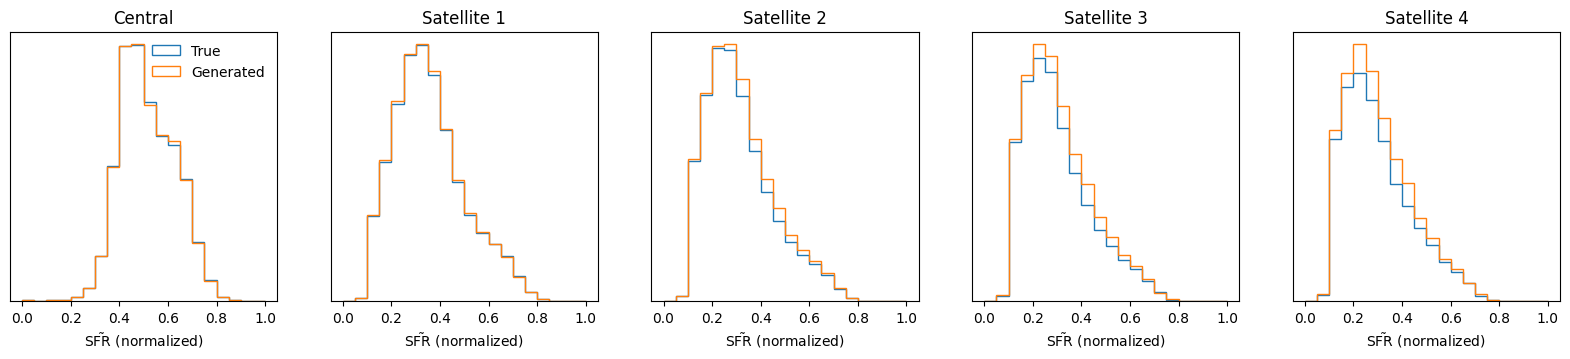

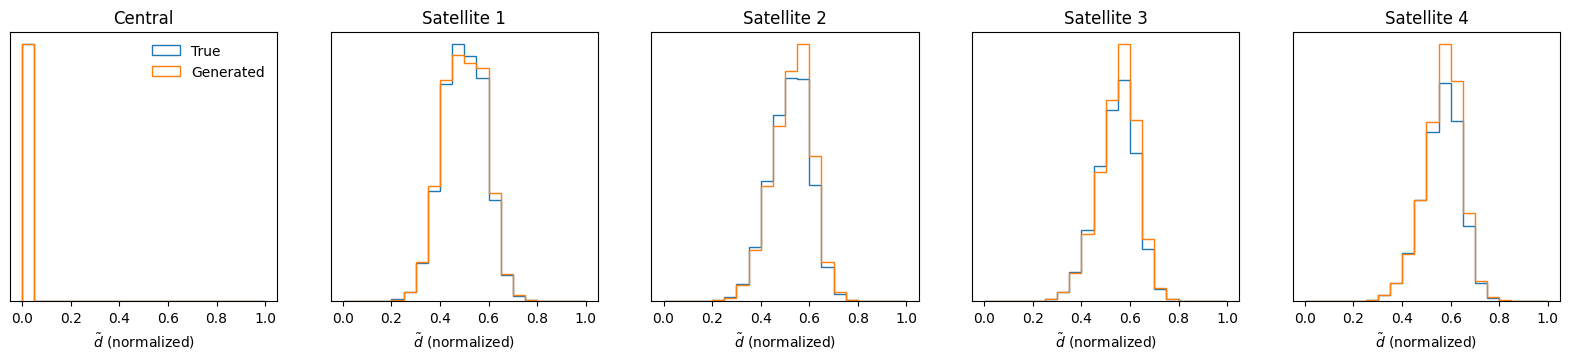

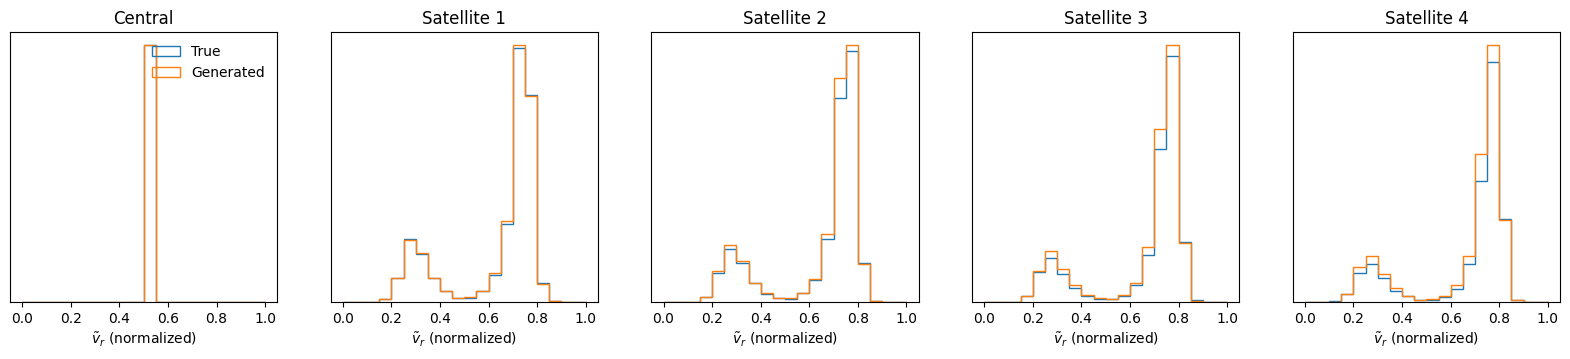

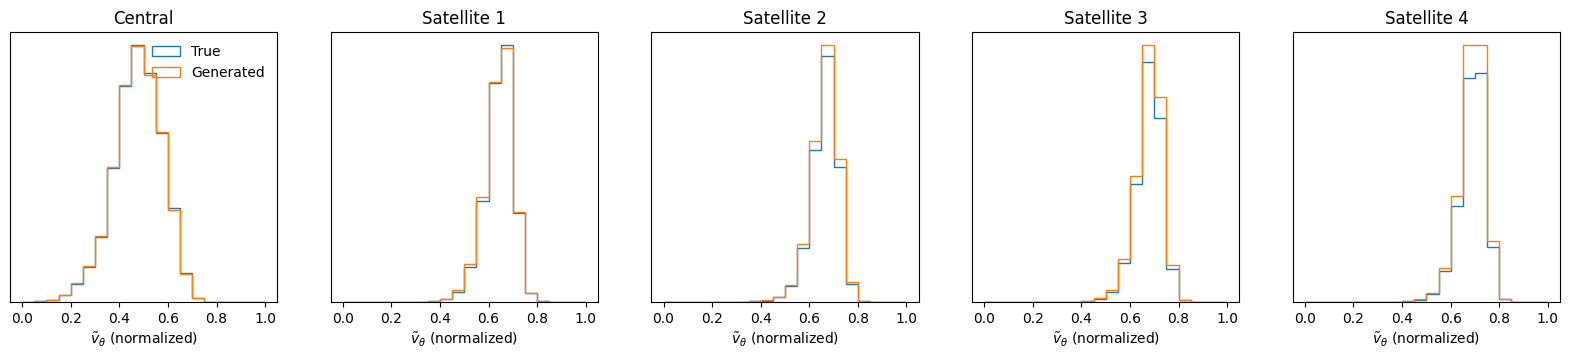

In [19]:
max_length_to_show = 5

for iparam in range(opt.num_features_in):
    ynow_true = y_true
    ynow = generated

    plt.figure(figsize=(20,3.5))
    for isat in range(max_length_to_show):
        plt.subplot(1,max_length_to_show,isat+1)
        if isat == 0:
            plt.title("Central")
        else:
            plt.title(f"Satellite {isat}")
            ynow_true = ynow_true[ynow_true[:,isat,0]>threshold]
            ynow = ynow[ynow[:,isat,0]>threshold]

        plt.hist(ynow_true[:,isat,iparam], histtype="step", bins=20, range=(0,1), label="True")
        plt.hist(ynow[:,isat,iparam], histtype="step", bins=20, range=(0,1), label="Generated")
        if isat == 0:
            plt.legend(loc="upper right", frameon=False)

        plt.xlabel(f"{param_names[iparam]} (normalized)")
        plt.yticks([])

[[0.00603135 0.00721535 0.00854495 0.01041907 0.01413714 0.01879817
  0.02380467 0.0296762  0.04145913 0.06087422 0.09491392 0.1403608
  0.21679773 0.35379526 1.01184903 0.49252788]
 [0.0060385  0.00723823 0.00859028 0.01049096 0.01420487 0.01877918
  0.02359159 0.0290667  0.04027286 0.05887962 0.08980299 0.12743377
  0.18520954 0.30736202 0.34785288 1.50747212]]
[[0.00609004 0.00749215 0.00905855 0.01107418 0.01439629 0.01879366
  0.02385559 0.03066068 0.0417178  0.06058575 0.09345566 0.14168086
  0.22925505 0.35294951 0.56126669 0.        ]
 [0.00609131 0.00750231 0.00908603 0.01112094 0.01443831 0.01877052
  0.02364916 0.03013747 0.04055936 0.05852957 0.08791174 0.12929757
  0.21223208 0.32479949 0.99183329        nan]]


/tmp/ipykernel_3949372/4198519840.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(num - 3)
/tmp/ipykernel_3949372/4198519840.py:12: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(r)
/tmp/ipykernel_3949372/4198519840.py:16: RuntimeWarning: invalid value encountered in scalar add
  upper_bound = np.tanh(z + z_alpha * se)


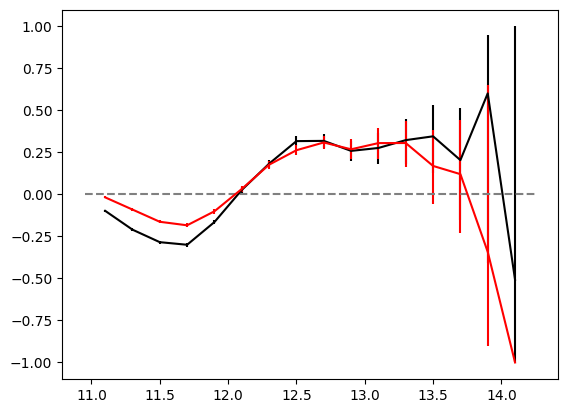

In [58]:
### Correlation coefficient between central SFR and total satellite SFR

def calc_corrcoef(x, y):
    x = x.flatten()
    y = y.flatten()
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    return np.corrcoef(x, y)[0, 1]

def confidence_interval(r, num):
    z = np.arctanh(r)
    se = 1 / np.sqrt(num - 3)
    z_alpha = 1.96 # 95% CI
    lower_bound = np.tanh(z - z_alpha * se)
    upper_bound = np.tanh(z + z_alpha * se)
    return r - lower_bound, upper_bound - r

x_values = []
corr_true_list = []
interval_true_list = []
corr_list = []
interval_list = []
for i in range(nbins-4):
    mask = (xbin_indices_true == i)
    x_values.append( 0.5 * (xbins_physical_unit[i,0] + xbins_physical_unit[i+1,0]) )

    y1now = y_true[mask][:,0,0]
    y2now = y_true_sat_tot[mask]
    r = calc_corrcoef(y1now, y2now)
    err_neg, err_pos = confidence_interval(r, len(y1now))

    corr_true_list.append(r)
    interval_true_list.append((err_neg, err_pos))

    y1now = generated[mask][:,0,0]
    y2now = y_generated_sat_tot[mask]

    r = calc_corrcoef(y1now, y2now)
    err_neg, err_pos = confidence_interval(r, len(y1now))

    corr_list.append(r)
    interval_list.append((err_neg, err_pos))

#plt.scatter(x_values, corr_true_list, label="True", color="black")
#plt.scatter(x_values, corr_list, label="Generated", color="red")

interval_true_list = np.array(interval_true_list).T
interval_list = np.array(interval_list).T

interval_true_list[interval_true_list < 0] = 0
interval_list[interval_list < 0] = 0

print(interval_true_list)
print(interval_list)
plt.errorbar(x_values, corr_true_list, interval_true_list, label="True", color="black")
plt.errorbar(x_values, corr_list, interval_list, label="Generated", color="red")

#plt.xlim([11, 13.5])

xlim = plt.xlim()
plt.plot(xlim, [0,0], color="gray", ls="dashed")


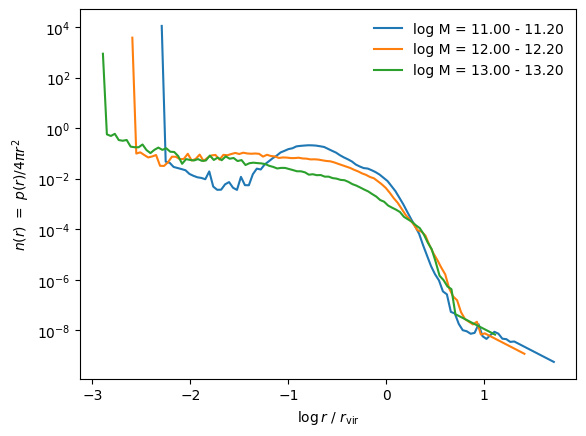

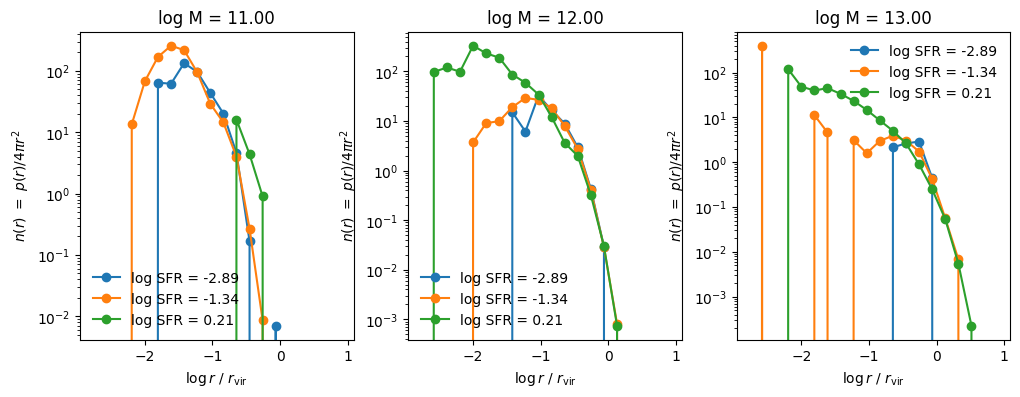

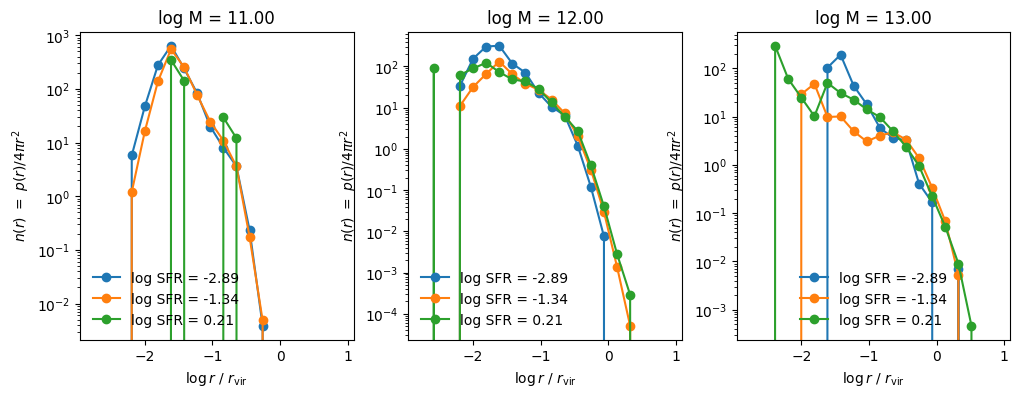

In [31]:
## radial profile
def NFW_profile(logr, log_rs=0, log_rho0=0):
    r = 10**logr 
    rs = 10**log_rs
    rho0 = 10**log_rho0
    return rho0 / (r/rs) / (1 + r/rs)**2
# concentration = rvir / rs = 1e-1 / 1 

nsample = 100

plt.figure()

list_to_show = [0, 5, 10]
for ibin in list_to_show:
    x_random = torch.rand(nsample).to(device) 
    x_random = x_random * (xbins[ibin+1] - xbins[ibin]) + xbins[ibin]
    generated_test, prob = model.generate(x_random)
    generated_test = generated_test.detach().cpu().numpy()
    prob = prob.detach().cpu().numpy()
    length_generated_test = calc_length(generated_test)

    r_profile = np.zeros(opt.num_features_out)
    count = 0
    for i, (x, g) in enumerate(zip(x_random, generated_test)):
        iparam = 1
        for k in range(1, length_generated_test[i]+1):
            r_profile += prob[i,k,iparam]
            count += 1
    logr = np.linspace(0, 1, opt.num_features_out) * (xmax[2] - xmin[2]) + xmin[2]
    r_profile /= count * 4 * np.pi * ( 10 ** logr ) ** 2

    logr_vir = np.log10( 0.39 ) + 0.3 * ( xbins_physical_unit[ibin, 0] - 12 )

    logr = logr - logr_vir

    plt.plot(logr, r_profile, label=f"log M = {xbins_physical_unit[ibin,0]:.2f} - {xbins_physical_unit[ibin+1,0]:.2f}")
    
plt.yscale("log")
plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")
#plt.xlabel(r"$\log r \ [{\rm Mpc}/h]$")
plt.legend(frameon=False)


list_to_show = [0, 5, 10]
y_list_to_show = [1, 6, 11]

plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {xbins_physical_unit[i_logm, 0]:.2f}")
    base_mask = (xbin_indices_true == i_logm)
    for j in y_list_to_show:
        ynow = y_true[base_mask]
        bin_indices_now = np.digitize(ynow[:,:,0], xbins) - 1
        ynow = ynow[bin_indices_now == j]

        hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
        logr = bins * (xmax[2] - xmin[2]) + xmin[2]
        logr = 0.5 * (logr[1:] + logr[:-1])
        hist /= 4 * np.pi * ( 10 ** logr ) ** 2

        plt.plot(logr, hist, label=f"log SFR = {xbins_physical_unit[j, 1]:.2f}", ls="-", marker="o")

    plt.yscale("log")
    plt.legend(frameon=False
               )
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")

plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {xbins_physical_unit[i_logm, 0]:.2f}")
    base_mask = (xbin_indices_true == i_logm)
    for j in y_list_to_show:
        ynow = generated[base_mask]
        bin_indices_now = np.digitize(ynow[:,:,0], xbins) - 1 
        ynow = ynow[bin_indices_now == j]

        hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
        logr = bins * (xmax[2] - xmin[2]) + xmin[2]
        logr = 0.5 * (logr[1:] + logr[:-1])
        hist /= 4 * np.pi * ( 10 ** logr ) ** 2

        plt.plot(logr, hist, label=f"log SFR = {xbins_physical_unit[j, 1]:.2f}", ls="-", marker="o")

    plt.yscale("log")
    plt.legend(frameon=False)
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r\ /\ r_{\rm vir} $")


In [ ]:
### Relation between SFR_0 and d_0
plt.figure()
plt.scatter(y_true[:,1,0], y_true[:,1,1], s=1)
plt.scatter(generated[:,1,0], generated[:,1,1], s=1)

plt.xlabel("log SFR")
plt.ylabel("log d")

In [ ]:
### Relation between SFR_0 and SFR_1 etc.
plt.figure()
plt.scatter(y_true[:,0,0], y_true[:,1,0], s=1)
plt.scatter(generated[:,0,0], generated[:,1,0], s=1)
plt.xlabel("log SFR 0")
plt.ylabel("log SFR 1")

list_to_show = [0, 5, 10]

plt.figure(figsize=(len(list_to_show)*4, 4))
for count, ihalo in enumerate(list_to_show):
    mask = (xbin_indices_true == ihalo)
    plt.subplot(1,len(list_to_show),count+1)
    plt.scatter(y_true[mask,0,0], y_true[mask,1,0], s=1)
    plt.scatter(generated[mask,0,0], generated[mask,1,0], s=1)
    plt.xlabel("log SFR 0")
    plt.ylabel("log SFR 1")

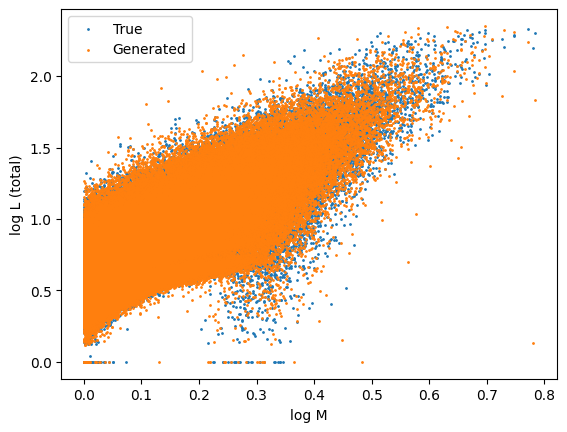

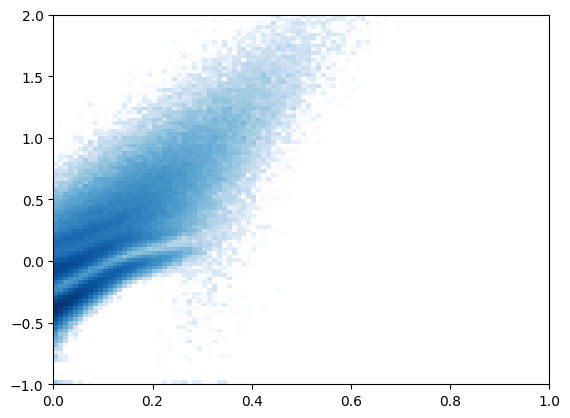

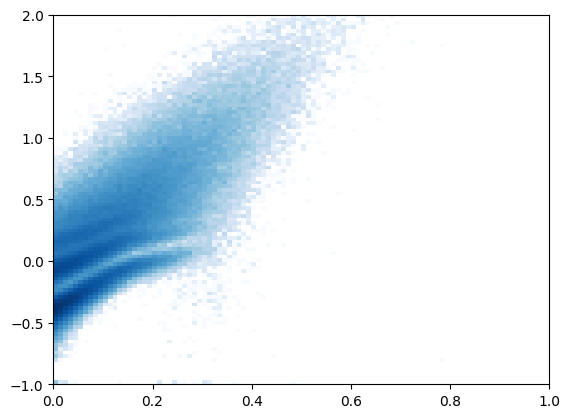

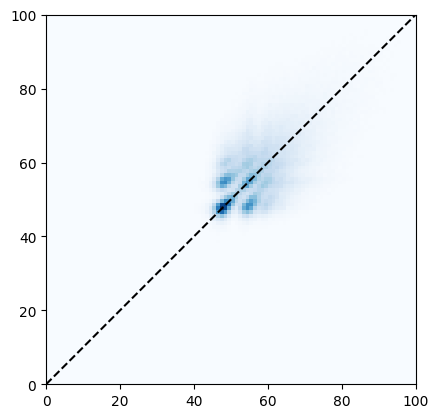

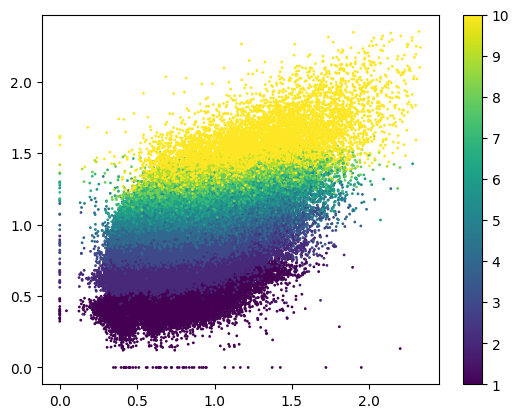

In [28]:
### True total vs generated total

plt.figure()
plt.scatter(x_true, y_true_tot, s=1, label="True")
plt.scatter(x_true, y_generated_tot, s=1, label="Generated") 
plt.xlabel("log M")
plt.ylabel("log L (total)")
plt.legend()

plt.figure()
hist = np.histogram2d(x_true, y_true_tot, bins=100, range=[[0,1],[0,2]])
plt.imshow(hist[0].T, extent=[0,1,-1,2], origin="lower", cmap="Blues", aspect="auto", norm=LogNorm())

plt.figure()
hist = np.histogram2d(x_true, y_generated_tot, bins=100, range=[[0,1],[0,2]])
plt.imshow(hist[0].T, extent=[0,1,-1,2], origin="lower", cmap="Blues", aspect="auto", norm=LogNorm())

plt.figure()

hist = np.histogram2d(y_true_tot, y_generated_tot, bins=100, range=[[-1,2],[-1,2]])
plt.imshow(hist[0].T, extent=[0,100,0,100], origin="lower", cmap="Blues")
plt.plot([0, 100], [0, 100], color="black", ls="--")

plt.figure()
plt.scatter(y_true_tot, y_generated_tot, c=length_generated, s=1, vmin=1, vmax=10)
plt.colorbar()


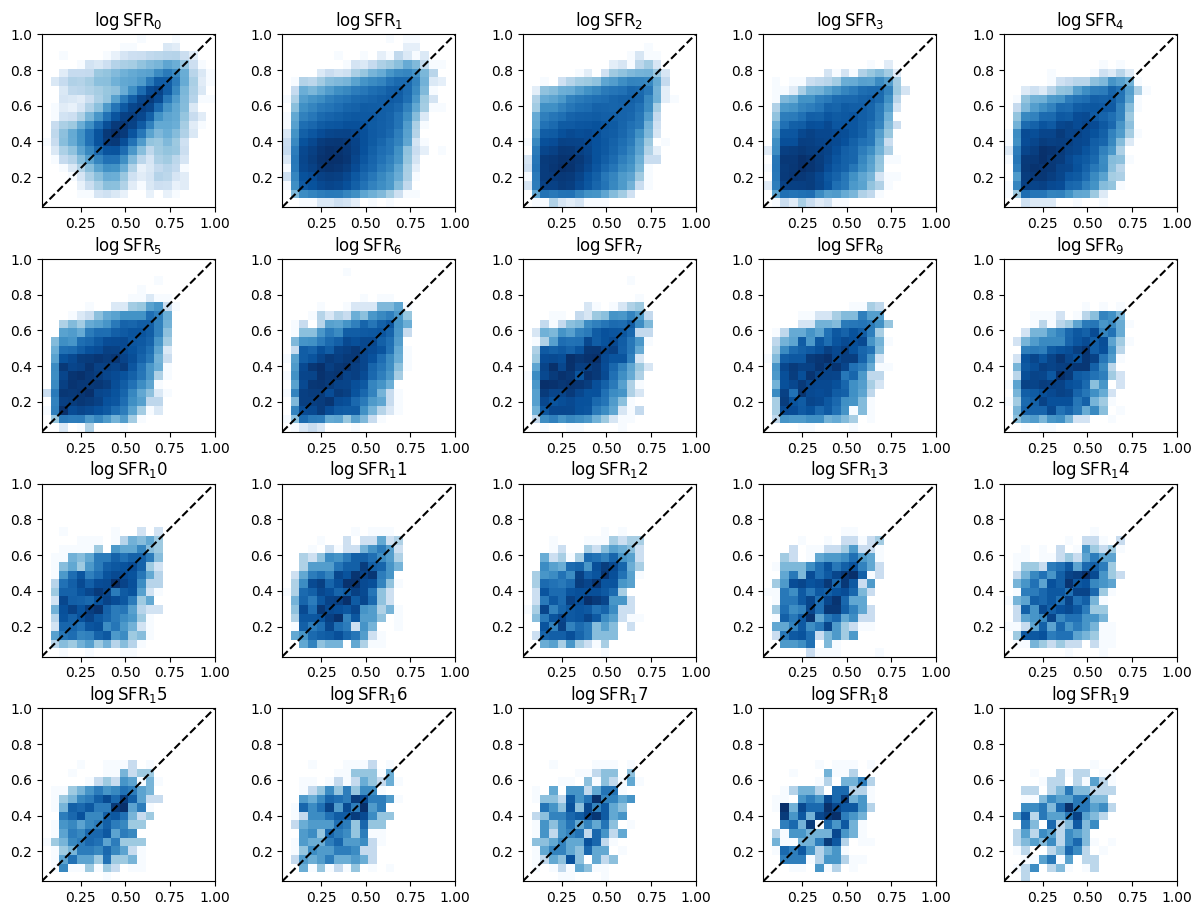

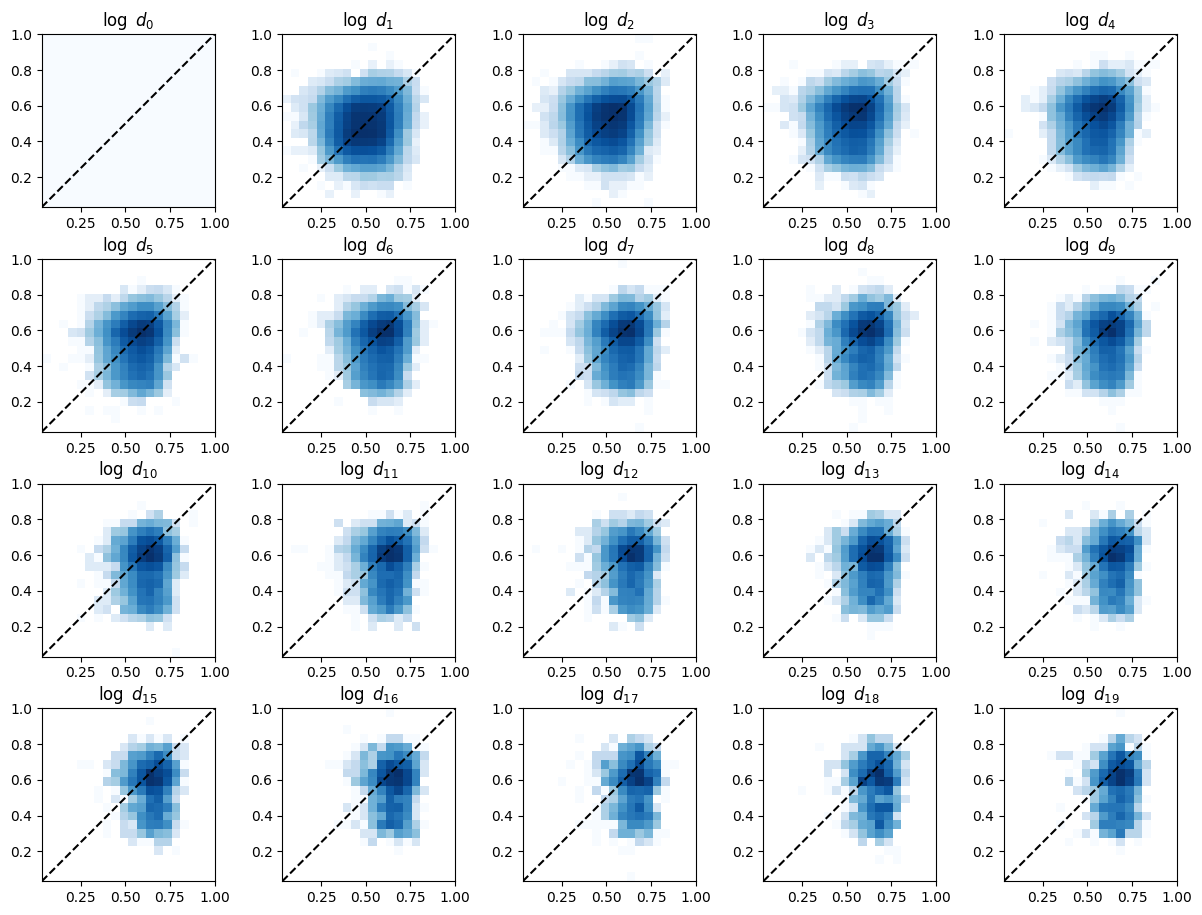

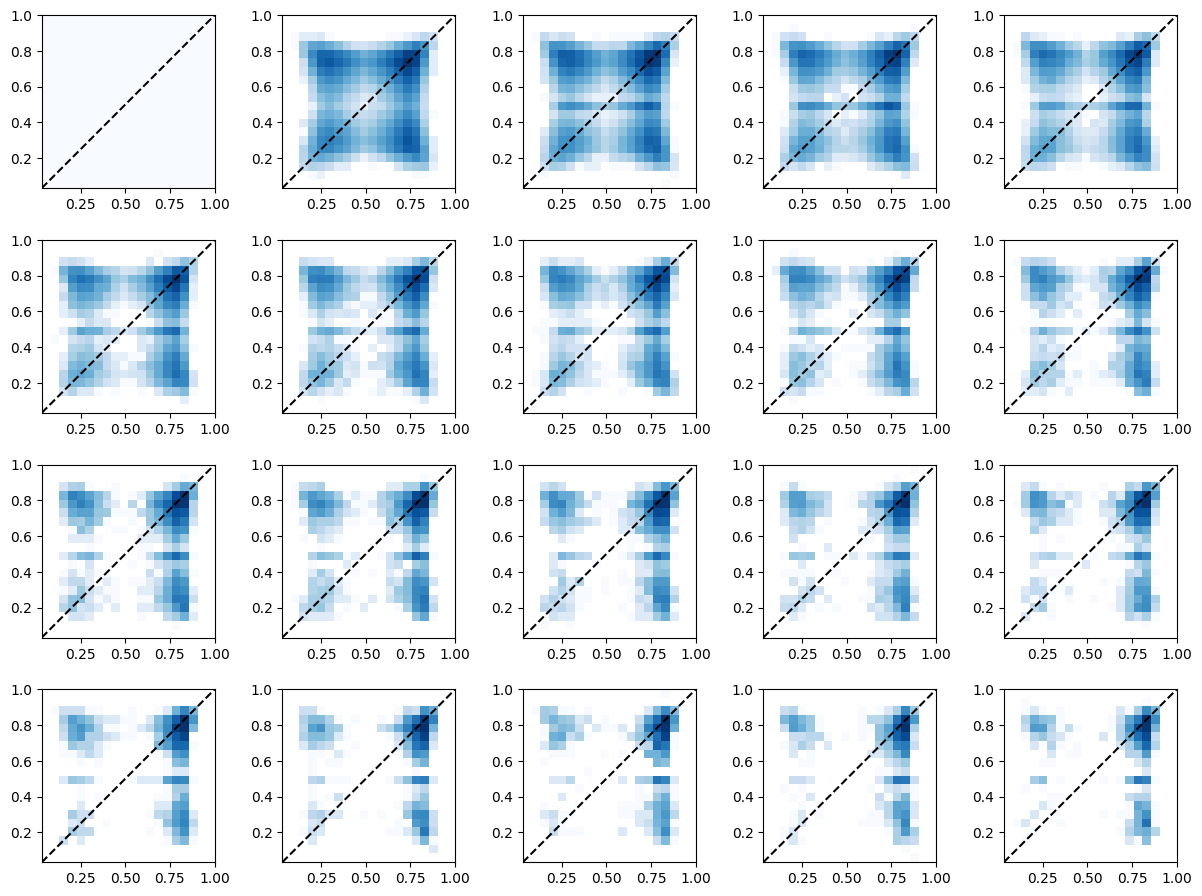

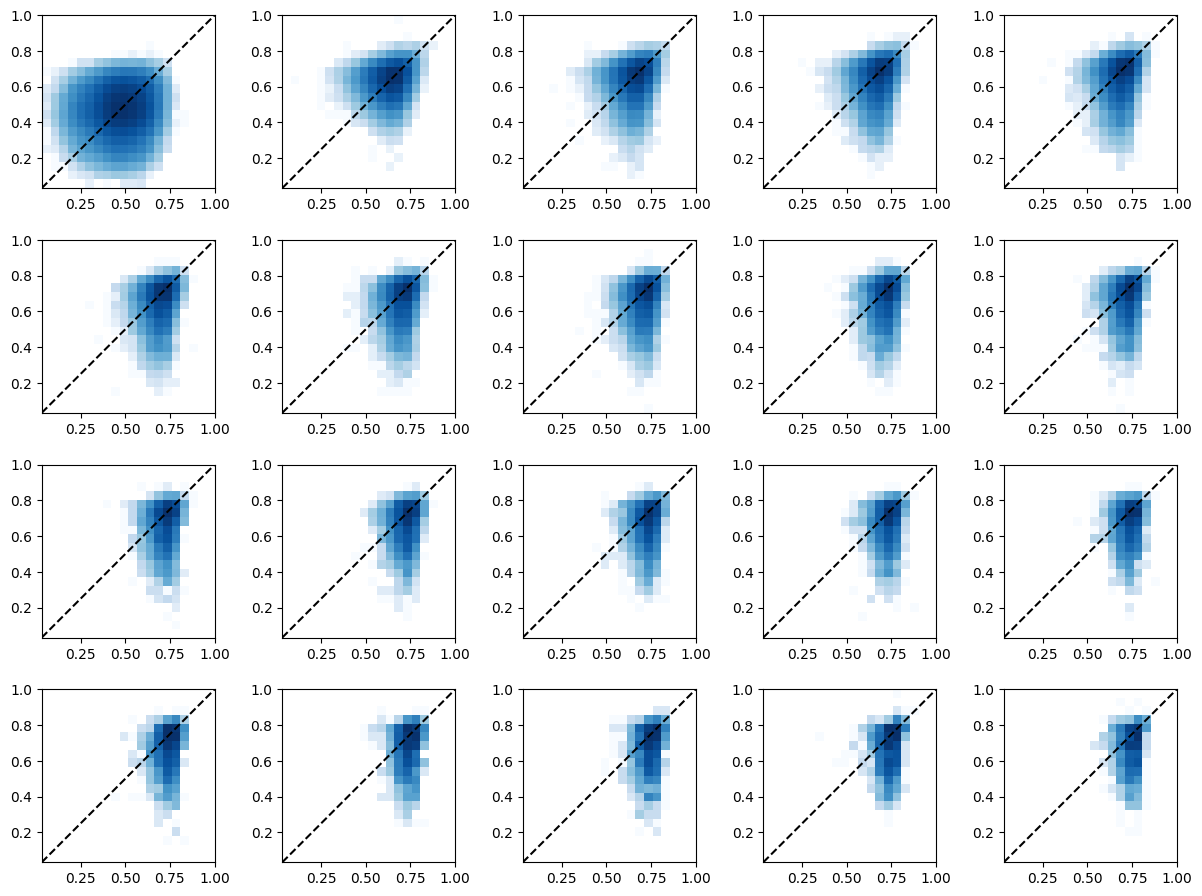

In [30]:
### True vs generated 
show_scatter = False #True

for iparam in range(opt.num_features_in):
    plt.figure(figsize=(15,11))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    for i in range(20):
        plt.subplot(4, 5, i+1)
        if iparam == 0:
            plt.title(r"$\rm \log SFR_%d$" %i)
        if iparam == 1:
            plt.title(r"$\log \ d_{\rm %d}$"%i)

        if show_scatter:
            plt.scatter(y_true[:,i,iparam], generated[:,i,iparam], s=1) #, c=length_generated, vmin=1, vmax=10)
        else:
            hist = np.histogram2d(y_true[:,i,iparam], generated[:,i,iparam], bins=20, range=[[threshold,1],[threshold,1]])
            plt.imshow(hist[0].T, extent=[threshold,1,threshold,1], origin="lower", cmap="Blues", norm=LogNorm())

        plt.plot([threshold, 1], [threshold, 1], color="black", ls="--")
        #plt.colorbar()
        plt.xlim(threshold, 1)
        plt.ylim(threshold, 1)


Saved figure to ./output/transformer1_33_use_vel/figures/attn_layer_0.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/attn_layer_1.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/attn_layer_2.pdf
Saved figure to ./output/transformer1_33_use_vel/figures/attn_layer_3.pdf


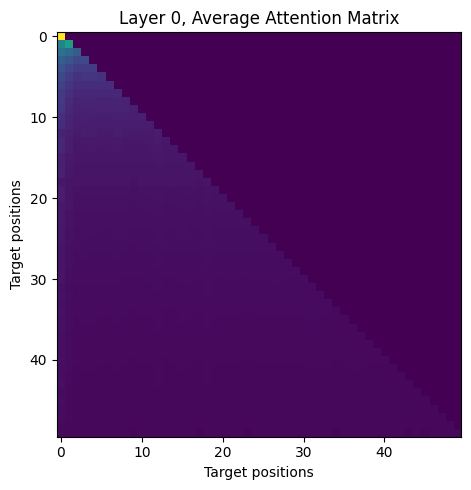

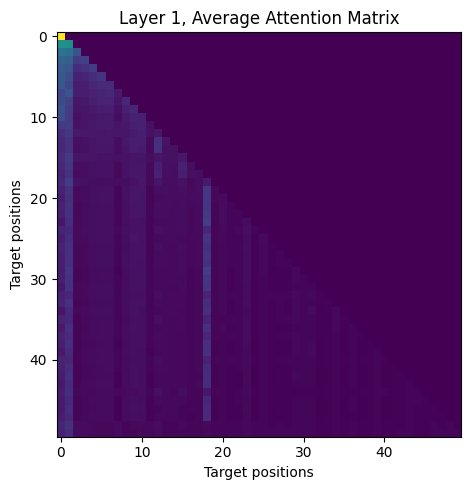

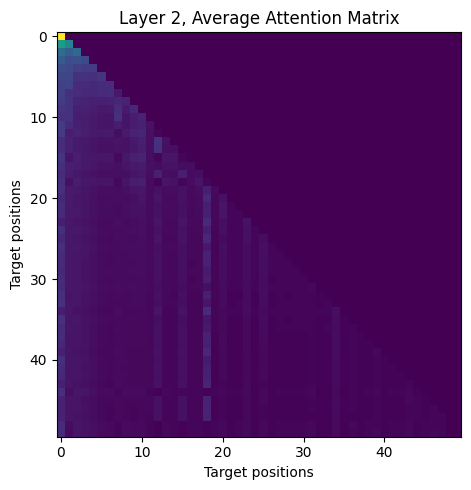

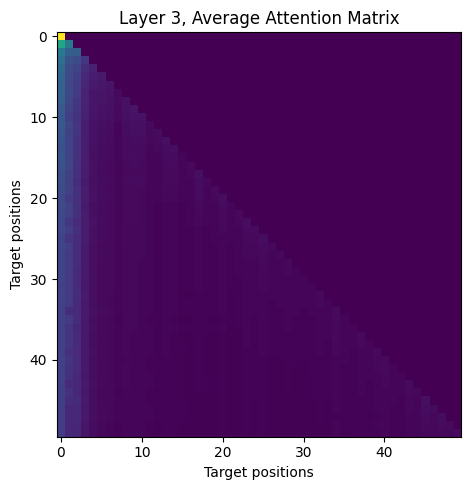

In [27]:
### Transformer attention visualization
opt_now = copy.deepcopy(opt)
opt_now.model_name = opt.model_name + "_with_attn"
model_now = my_model(opt_now)
model_now.to(device)

model_now.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model_now.eval()

attn_weights = {}

def get_hook(name):
    def hook(module, input, output):
        attn_weights[name] = output[1].detach().cpu() 
    return hook

for i, layer in enumerate(model_now.decoder.layers):
    layer.self_attn.register_forward_hook(get_hook(f'layer_{i}_self_attn'))

con = torch.from_numpy(x_true[0:1]).unsqueeze(-1).to(device)
seq = torch.from_numpy(y_true[0:1,:-1,:]).to(device)

output = model_now(con, seq)

for i in range(opt_now.num_layers):
    attn_matrix = attn_weights[f'layer_{i}_self_attn'][0].numpy()  # (tgt_len, tgt_len)

    plt.figure(figsize=(5, 5))
    plt.imshow(attn_matrix, cmap='viridis')
    #plt.colorbar()
    plt.title(f"Layer {i}, Average Attention Matrix")
    plt.xlabel("Target positions")
    plt.ylabel("Target positions")

    plt.tight_layout()
    my_savefig(f"{output_dir}/attn_layer_{i}.pdf")
